In [10]:
test_mp4, test_depth, test_intr = "./raw_data/rgb_20250712_110449", "./raw_data/depth_20250712_110449", "./raw_data/intrinsics_20250712_110449"

In [11]:
import cv2
from frame_processor import FrameProcessor
from mock_camera import MockCamera

from config import Config 

camera_intrinsics = Config.CAMERA_INTRINSICS
#Config.CAMERA_INTRINSICS

camera = MockCamera(rgb_folder=test_mp4, depth_folder=test_depth, intrinsics_folder=test_intr)
processor = FrameProcessor(camera_intrinsics)
processor.set_tracking_enabled(True)
camera.start()

# Обработка и отображение
while True:
   color, depth, depth_intrinsics= camera.get_frames()
   if color is None or depth is None:
       break
   
   # Обработка кадра
   results = processor.process_frame(color, depth, depth_intrinsics)
   
   # Отображение результата (combined = RGB + Depth + Cleaned)
   cv2.imshow('Processed Video', results['combined'])
   
   # Или только обработанный RGB с масками
   # cv2.imshow('Processed Video', results['color_with_mask'])
   
   if cv2.waitKey(25) & 0xFF == ord('q'):
       break

camera.stop()
cv2.destroyAllWindows()

# Вывод статистики
print(f"Обработано кадров: {processor.frame_count}")

TOP DIMENSIONS:
0: [     1.2074      0.5512     0.32989]
1: [    0.94428     0.44416     0.39222]
2: [     1.4218     0.57988     0.41505]
3: [      1.095     0.60188     0.40262]
4: [    0.86684     0.51353     0.18349]
5: [    0.86807     0.45898      0.2319]
Object 0: габариты 1.207x0.551x0.330 м, объем 0.2195 м³, 1250 точек
Обработано кадров: 126


In [12]:
import numpy as np
completed_objects = processor.get_completed_objects()
print(f"\nЗавершено объектов: {len(completed_objects)}")

# Анализ результатов
for idx, obj in enumerate(completed_objects):
    print(f"\n Объект №: {idx}")
    print(f"  Точек в облаке: {len(obj['point_cloud'])}")
    print(f"  Всего масок: {len(obj['all_masks'])}")
    print(f"  Габариты: {obj['dimensions'][0]:.3f}x{obj['dimensions'][1]:.3f}x{obj['dimensions'][2]:.3f} м, ")


Завершено объектов: 1

 Объект №: 0
  Точек в облаке: 1250
  Всего масок: 40
  Габариты: 1.207x0.551x0.330 м, 


In [13]:
import open3d as o3d
import numpy as np

def visualize_point_cloud_with_bbox(result):
    """Визуализация облака точек с ориентированным bounding box"""
    # Создаем облако точек
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(result['point_cloud'])
    pcd.paint_uniform_color([0.5, 0.5, 0.5])
    
    # Создаем линии для отображения bounding box
    bbox_lines = create_bbox_lines(result['centroid'], result['dimensions'], result['rotation_matrix'])
    
    # Текст с размерами
    print(f"Габариты: {result['dimensions'][0]:.3f} x {result['dimensions'][1]:.3f} x {result['dimensions'][2]:.3f} м")
    print(f"Объем: {result['volume']:.4f} м³")
    print(f"Точек: {result['num_points']}")
    
    # Визуализация
    o3d.visualization.draw_geometries(
        [pcd, bbox_lines],
        window_name="Облако точек с габаритами",
        width=800, height=600
    )

def create_bbox_lines(center, extent, rotation):
    """Создание линий bounding box"""
    # Вершины box в локальных координатах
    corners = np.array([
        [-extent[0]/2, -extent[1]/2, -extent[2]/2],
        [extent[0]/2, -extent[1]/2, -extent[2]/2],
        [extent[0]/2, extent[1]/2, -extent[2]/2],
        [-extent[0]/2, extent[1]/2, -extent[2]/2],
        [-extent[0]/2, -extent[1]/2, extent[2]/2],
        [extent[0]/2, -extent[1]/2, extent[2]/2],
        [extent[0]/2, extent[1]/2, extent[2]/2],
        [-extent[0]/2, extent[1]/2, extent[2]/2]
    ])
    
    # Поворот и смещение
    corners = (rotation @ corners.T).T + center
    
    # Индексы линий
    lines = [[0,1],[1,2],[2,3],[3,0],
             [4,5],[5,6],[6,7],[7,4],
             [0,4],[1,5],[2,6],[3,7]]
    
    # Создание LineSet
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(corners)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in lines])
    
    return line_set

In [15]:
IDX = 0
visualize_point_cloud_with_bbox(completed_objects[IDX])

Габариты: 1.207 x 0.551 x 0.330 м
Объем: 0.2195 м³
Точек: 1250


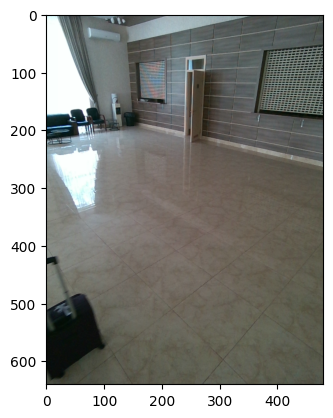

In [16]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(completed_objects[IDX]['rgb_image'], cv2.COLOR_BGR2RGB))

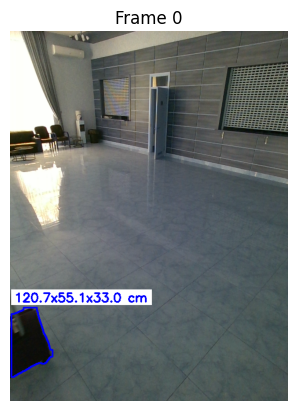

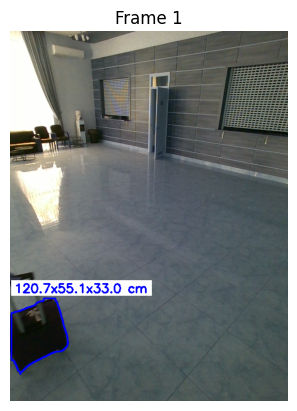

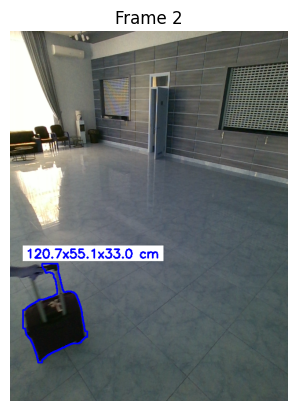

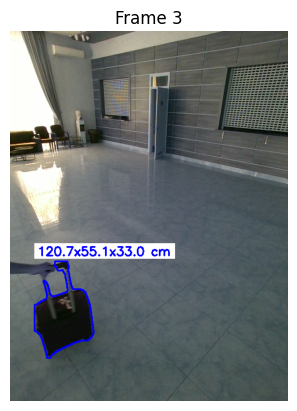

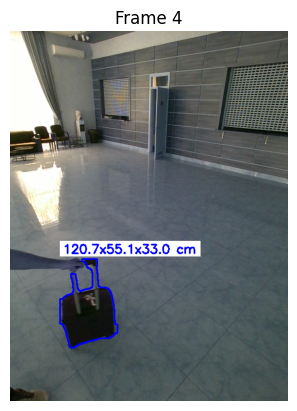

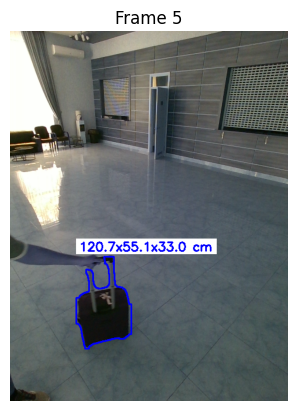

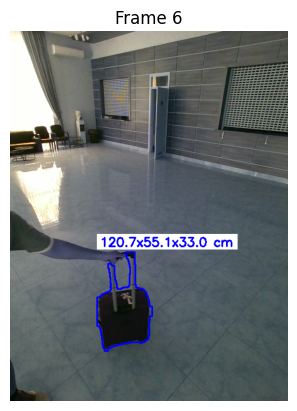

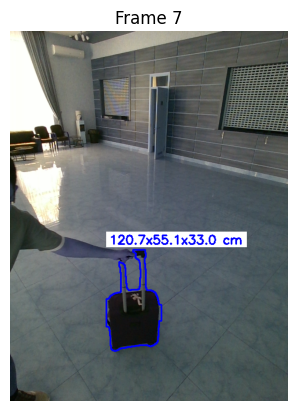

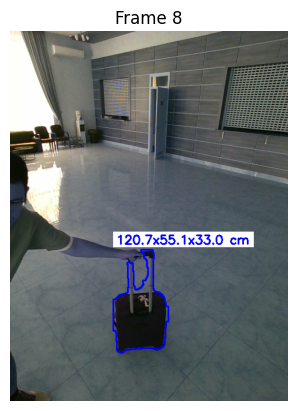

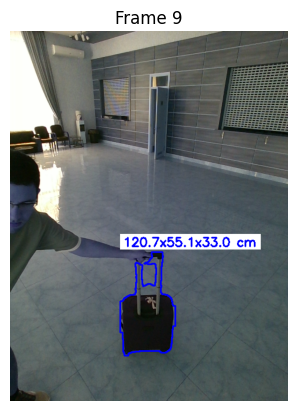

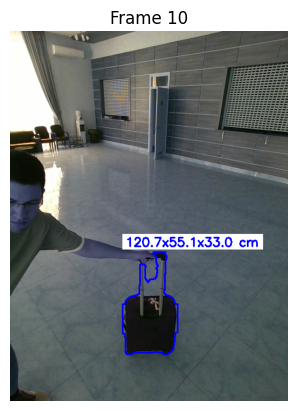

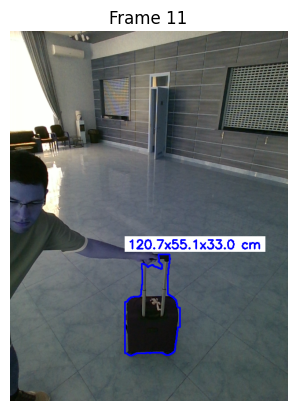

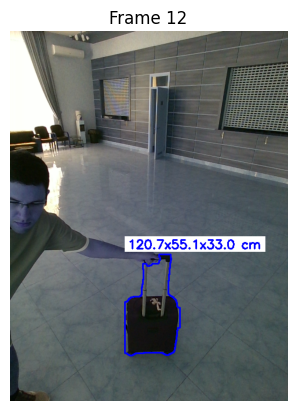

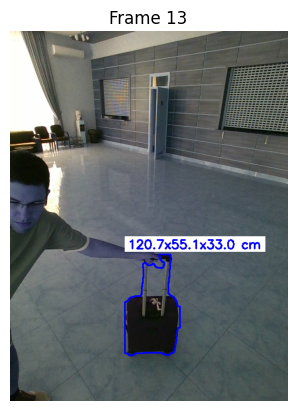

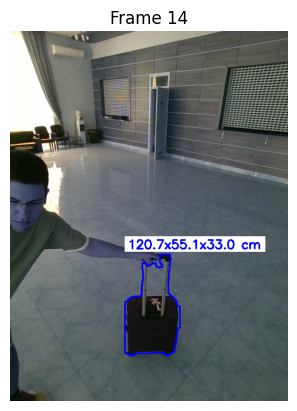

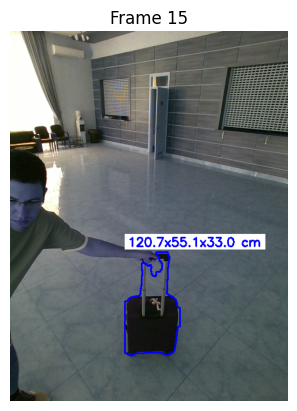

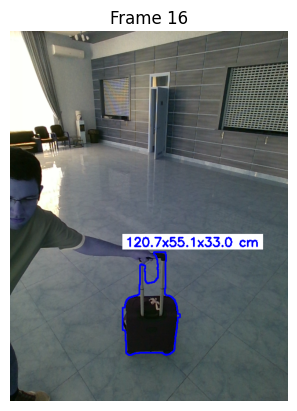

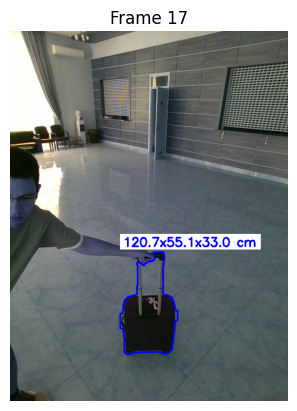

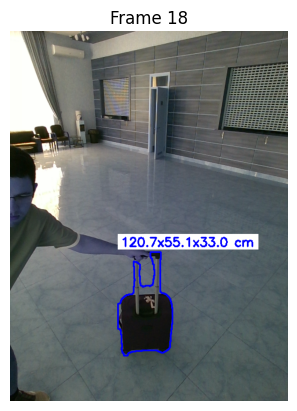

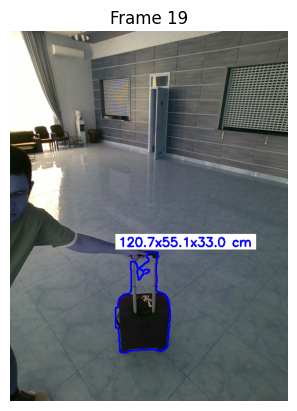

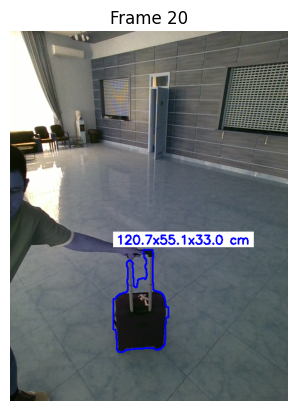

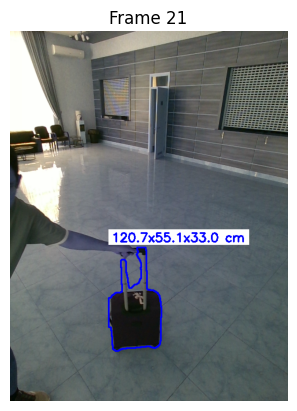

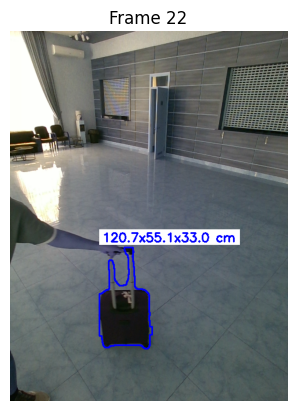

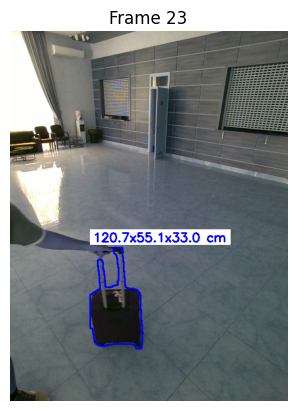

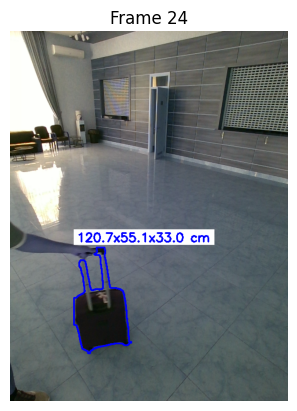

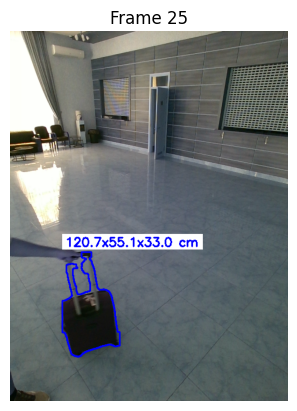

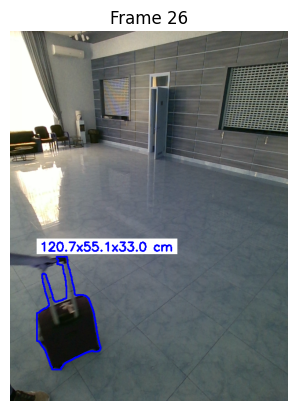

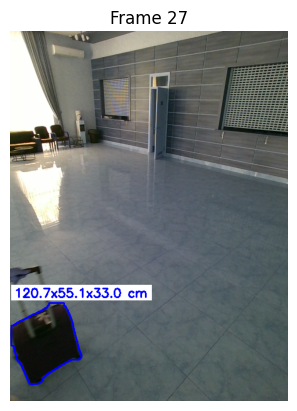

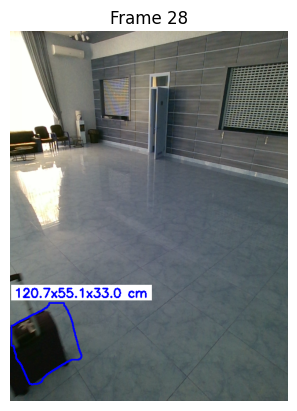

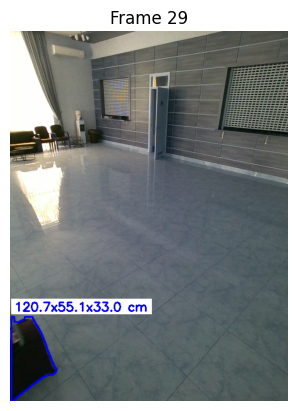

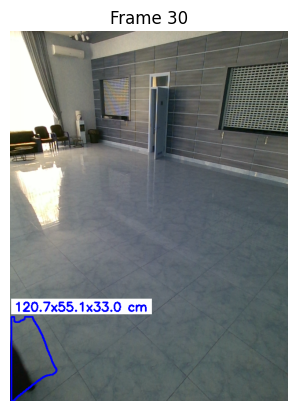

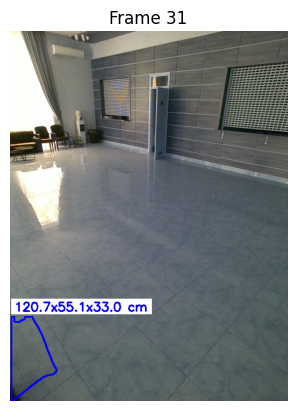

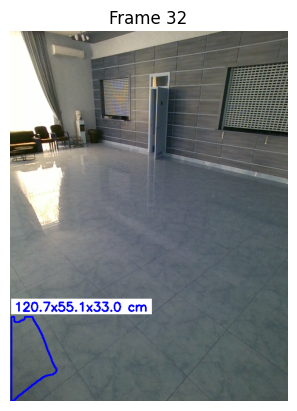

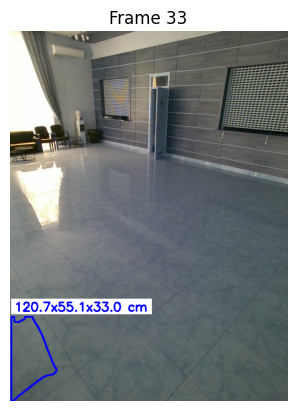

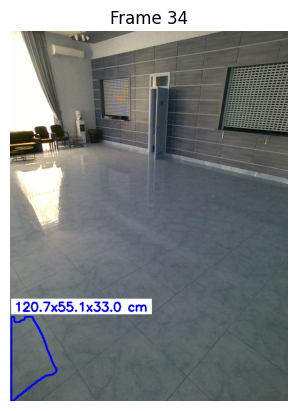

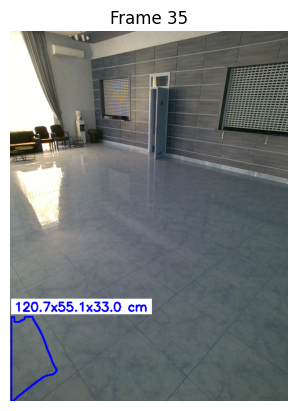

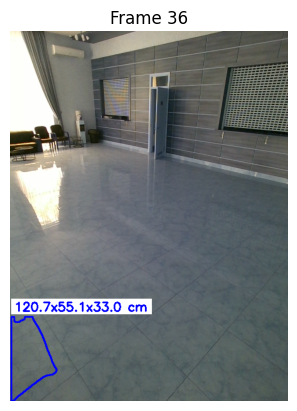

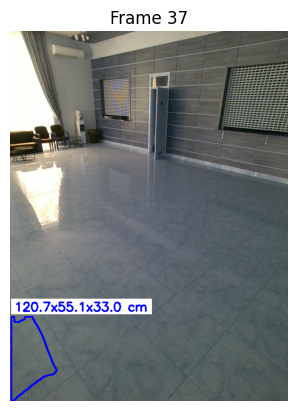

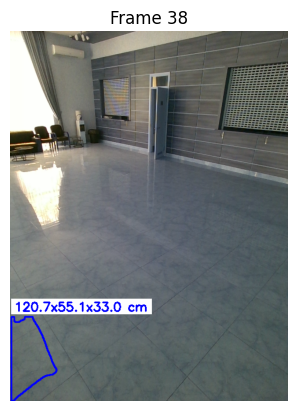

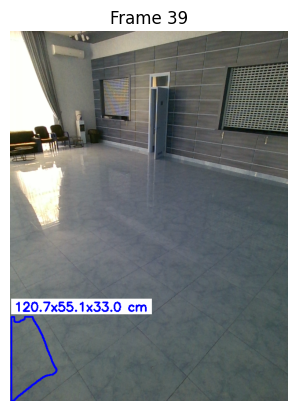

<Figure size 640x480 with 0 Axes>

In [17]:
#all_masks = completed_objects[IDX]['all_masks']
import time
import matplotlib.pyplot as plt

obj = completed_objects[IDX]

for i in range(len(obj['all_masks'])):
    obj['best_frame_index'] = i
    vis = processor.create_object_visualization(obj, [1, 1, 1])

    plt.imshow(vis)
    plt.axis('off')
    plt.title(f'Frame {i}')
    plt.pause(0.5)  # Задержка между кадрами
    plt.clf()       # Очистка перед следующим изображением


In [8]:
for i in range(10):
    print(obj['all_masks'][i]['mask'].mean())

8.851123046875
11.352978515625
13.376708984375
13.126025390625
13.126025390625
11.14794921875
11.14794921875
11.14794921875
11.14794921875
9.460400390625
